# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

In [2]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 4
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 0s 0us/step


### Project Model

In [5]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(64, return_sequences=True)))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dense(32, activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 128)            164352    
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 7, 64)             8256      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 32)             2

In [6]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True       
                
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 132s 295ms/step - loss: 1.3656 - acc: 0.4449 - val_loss: 1.9173 - val_acc: 0.1212
Epoch 2/30
380/380 [==============================] - 91s 238ms/step - loss: 0.8473 - acc: 0.7253 - val_loss: 1.8668 - val_acc: 0.3035
Epoch 3/30
380/380 [==============================] - 95s 250ms/step - loss: 0.5296 - acc: 0.8523 - val_loss: 0.4988 - val_acc: 0.8666
Epoch 4/30
380/380 [==============================] - 91s 239ms/step - loss: 0.3793 - acc: 0.8885 - val_loss: 0.3201 - val_acc: 0.8870
Epoch 5/30
380/380 [==============================] - 91s 238ms/step - loss: 0.3084 - acc: 0.9039 - val_loss: 0.4301 - val_acc: 0.8310
Epoch 6/30
380/380 [==============================] - 90s 237ms/step - loss: 0.2638 - acc: 0.9158 - val_loss: 0.3747 - val_acc: 0.8697
Epoch 7/30
380/380 [==============================] - 90s 237ms/step - loss: 0.2312 - acc: 0.9270 - val_loss: 0.2856 - val_acc: 0.8870
Epoch 8/30
380/380 [==============================] - 

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

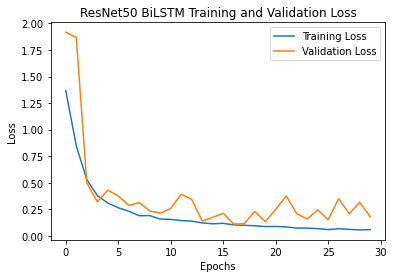

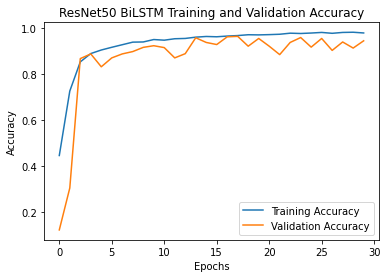

In [7]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 7s 26ms/step - loss: 0.1787 - acc: 0.9440
Loss: 0.17870168387889862
Accuracy: 0.9439918398857117


In [9]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 83s 214ms/step

ResNet50 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20776   0.21066   0.20920      1220
            covid19    0.21434   0.21641   0.21537      1243
             normal    0.20216   0.19676   0.19943      1235
       tuberculosis    0.19426   0.19658   0.19541      1170
    viral_pneumonia    0.19218   0.19059   0.19138      1212

           accuracy                        0.20230      6080
          macro avg    0.20214   0.20220   0.20216      6080
       weighted avg    0.20226   0.20230   0.20227      6080



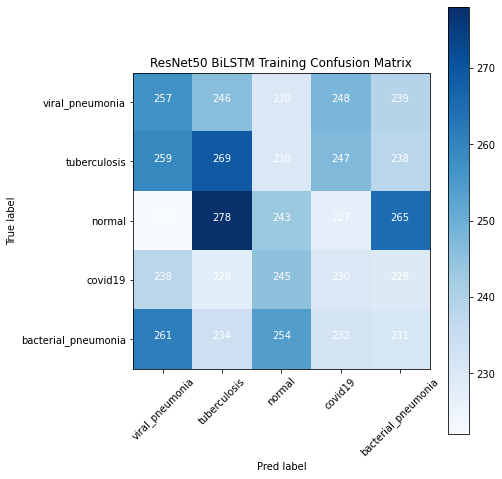

In [10]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [11]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = True

80150528/80134624 [==============================] - 0s 0us/step


### Our Model

In [12]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(64, return_sequences=True)))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(64, activation='relu'))
model_VGG19.add(Dense(32, activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 128)            164352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 64)             8256      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 32)            

In [13]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
    #callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 119s 285ms/step - loss: 1.2479 - acc: 0.4597 - val_loss: 0.9053 - val_acc: 0.6640
Epoch 2/30
380/380 [==============================] - 104s 274ms/step - loss: 0.8564 - acc: 0.6535 - val_loss: 0.7718 - val_acc: 0.6762
Epoch 3/30
380/380 [==============================] - 104s 274ms/step - loss: 0.6492 - acc: 0.7640 - val_loss: 0.6310 - val_acc: 0.7230
Epoch 4/30
380/380 [==============================] - 105s 275ms/step - loss: 0.5245 - acc: 0.8099 - val_loss: 0.6920 - val_acc: 0.6721
Epoch 5/30
380/380 [==============================] - 104s 274ms/step - loss: 0.4553 - acc: 0.8385 - val_loss: 0.7914 - val_acc: 0.6823
Epoch 6/30
380/380 [==============================] - 105s 275ms/step - loss: 0.3891 - acc: 0.8602 - val_loss: 0.5028 - val_acc: 0.7658
Epoch 7/30
380/380 [==============================] - 104s 274ms/step - loss: 0.3646 - acc: 0.8715 - val_loss: 0.3645 - val_acc: 0.8717
Epoch 8/30
380/380 [============================

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

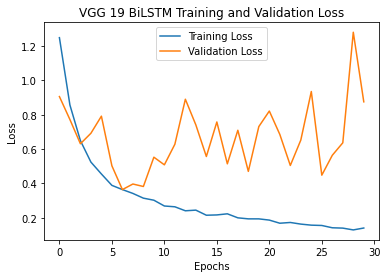

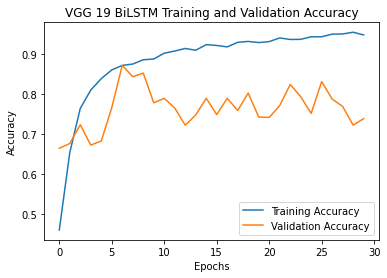

In [14]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 9s 36ms/step - loss: 0.8748 - acc: 0.7383
Loss: 0.8747924566268921
Accuracy: 0.7382891774177551


In [16]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 83s 216ms/step

VGG 19 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20993   0.22869   0.21891      1220
            covid19    0.19123   0.18584   0.18849      1243
             normal    0.21243   0.21862   0.21548      1235
       tuberculosis    0.18589   0.18462   0.18525      1170
    viral_pneumonia    0.18829   0.17244   0.18002      1212

           accuracy                        0.19819      6080
          macro avg    0.19755   0.19804   0.19763      6080
       weighted avg    0.19767   0.19819   0.19777      6080



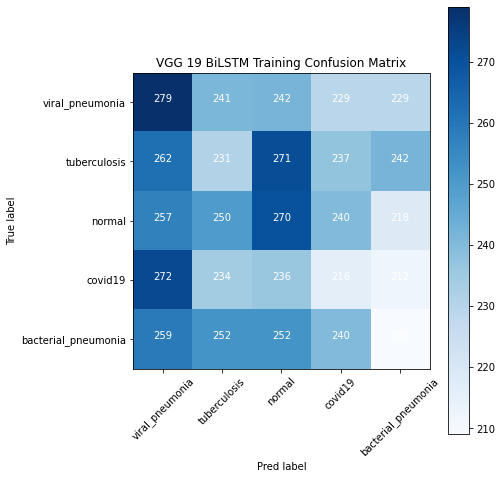

In [17]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [18]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(224, 224, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(64, activation='relu'))
model_InceptionV3.add(Dense(32, activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 128)            164352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             8256      
_________________________________________________________________
dense_7 (Dense)              (None, 5, 32)            

In [20]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True              
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator#,
   # callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 107s 246ms/step - loss: 1.4099 - acc: 0.4421 - val_loss: 1.1143 - val_acc: 0.6110
Epoch 2/30
380/380 [==============================] - 89s 233ms/step - loss: 0.9455 - acc: 0.6411 - val_loss: 0.7795 - val_acc: 0.6538
Epoch 3/30
380/380 [==============================] - 90s 236ms/step - loss: 0.7134 - acc: 0.7352 - val_loss: 0.6137 - val_acc: 0.7749
Epoch 4/30
380/380 [==============================] - 90s 236ms/step - loss: 0.5807 - acc: 0.7956 - val_loss: 0.5755 - val_acc: 0.7505
Epoch 5/30
380/380 [==============================] - 90s 237ms/step - loss: 0.5260 - acc: 0.8192 - val_loss: 0.4978 - val_acc: 0.7770
Epoch 6/30
380/380 [==============================] - 89s 234ms/step - loss: 0.4563 - acc: 0.8477 - val_loss: 0.5328 - val_acc: 0.7566
Epoch 7/30
380/380 [==============================] - 89s 235ms/step - loss: 0.3930 - acc: 0.8683 - val_loss: 0.5206 - val_acc: 0.7678
Epoch 8/30
380/380 [==============================] - 

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

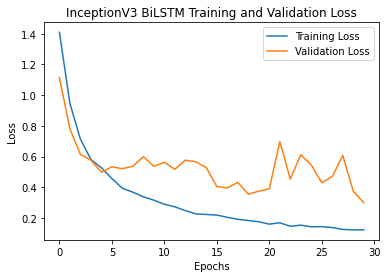

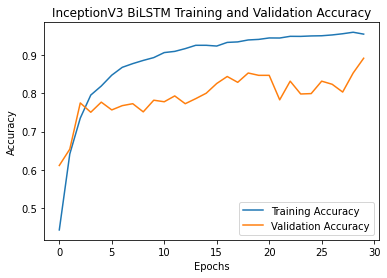

In [21]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 7s 27ms/step - loss: 0.2990 - acc: 0.8921
Loss: 0.29900622367858887
Accuracy: 0.8920570015907288


In [23]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 BiLSTM Training classification report:\n", train_class_report)



380/380 [==============================] - 84s 215ms/step

InceptionV3 BiLSTM Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19605   0.19508   0.19556      1220
            covid19    0.19852   0.19469   0.19659      1243
             normal    0.20733   0.21538   0.21128      1235
       tuberculosis    0.20990   0.21026   0.21008      1170
    viral_pneumonia    0.22232   0.21865   0.22047      1212

           accuracy                        0.20674      6080
          macro avg    0.20682   0.20681   0.20679      6080
       weighted avg    0.20675   0.20674   0.20672      6080



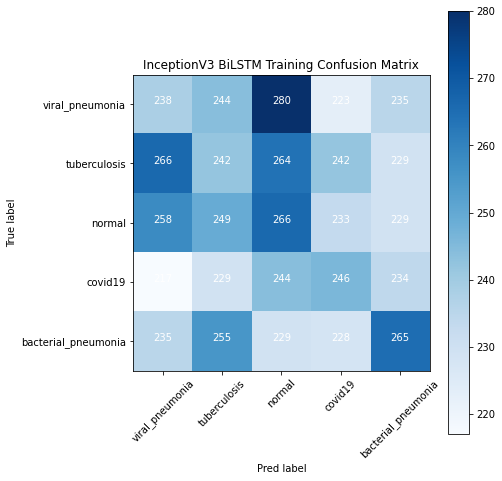

In [24]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 BiLSTM Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()